In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym
%matplotlib inline
from IPython import display
from utils_a2c import compute_df_dtheta, compute_dfpron_dthetapron
from models import ActorNetwork, ValueNetwork

In [1]:
random_seed = 21
torch.cuda.manual_seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
    
STEP = 2000
SAMPLE_NUMS = 30

def roll_out(actor_network,task,sample_nums,value_network,init_state):
    #task.reset()
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state

    for j in range(sample_nums):
        states.append(state)
        log_softmax_action = actor_network(Variable(torch.Tensor([state])))
        softmax_action = torch.exp(log_softmax_action)
        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        next_state,reward,done,_ = task.step(action)
        #fix_reward = -10 if done else 1
        actions.append(one_hot_action)
        rewards.append(reward)
        final_state = next_state
        state = next_state
        if done:
            is_done = True
            state = task.reset()
            break
    if not is_done:
        final_r = value_network(Variable(torch.Tensor([final_state]))).cpu().data.numpy()

    return states,actions,rewards,final_r,state

def discount_reward(r, gamma, final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma.detach().numpy() + r[t]
        discounted_r[t] = running_add
    return discounted_r

def discount_reward_grad(r, gamma, final_r):
    discounted_r = torch.zeros_like(torch.tensor(rewards))
    running_add = torch.reshape(torch.tensor(final_r), (1,1))
    for t in reversed(range(0, len(rewards))):
        running_add = running_add * gamma + torch.tensor(rewards[t])
        discounted_r[t] = running_add
    return discounted_r


# gym_name = "Pong-ram-v0"
# gym_name = "MountainCar-v0"
gym_name = "CartPole-v1"

# init a task generator for data fetching
task = gym.make(gym_name)
task.seed(random_seed)
init_state = task.reset()

discrete = isinstance(task.action_space, gym.spaces.Discrete)
STATE_DIM = task.observation_space.shape[0]
ACTION_DIM = task.action_space.n if discrete else task.action_space.shape[0]

# init value network
value_network = ValueNetwork(input_size = STATE_DIM,hidden_size = 40,output_size = 1)
value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

# init actor network
actor_network = ActorNetwork(STATE_DIM,40,ACTION_DIM)
actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

steps =[]
task_episodes =[]
test_results =[]

pi_list = []
value_list = []
expected_return_list = []

gamma_buffer = []
angle_buffer = []
target_value_buffer = []
estimate_value_buffer = []

gamma = torch.tensor(0.99, requires_grad=True)

for step in range(STEP):
    states,actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
    init_state = current_state
    actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
    states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))

    actor_network.zero_grad()
    actor_network_optim.zero_grad()
    value_network.zero_grad()
    value_network_optim.zero_grad()

    # train actor network
    log_softmax_actions = actor_network(states_var)
    vs = value_network(states_var).detach()
    # calculate qs
#     qs = Variable(torch.Tensor(discount_reward(rewards,0.99,final_r)))
    qs = Variable(torch.Tensor(discount_reward(rewards,gamma,final_r)))

    advantages = qs - vs
    actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
    actor_network_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(actor_network.parameters(),0.5)

    # train value network
    target_values = qs
    values = value_network(states_var)
    criterion = nn.MSELoss()
    value_network_loss = criterion(values.view(-1),target_values)
    value_network_loss.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(value_network.parameters(),0.5)
    
    pi_ = torch.mean(log_softmax_actions*actions_var)
    values_ = (values).pow(2).mean()
    return_ = discount_reward_grad(rewards,gamma,final_r).mean()
    f, f1, f2 = compute_df_dtheta(pi_, values_, return_, actor_network, value_network, gamma)
    
    actor_network_optim.step()
    value_network_optim.step()
    
    target_value_buffer.append(target_values.numpy().mean())
    estimate_value_buffer.append(values.detach().numpy().mean())
    
    # Meta gradient computation

    states,actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
    actions_var = Variable(torch.Tensor(actions).view(-1,ACTION_DIM))
    states_var = Variable(torch.Tensor(states).view(-1,STATE_DIM))

    actor_network.zero_grad()
    actor_network_optim.zero_grad()
    value_network.zero_grad()
    value_network_optim.zero_grad()

    # train actor network
    log_softmax_actions = actor_network(states_var)    
    pi_ = torch.mean(log_softmax_actions*actions_var)
    values = value_network(states_var)
    values_ = (values).pow(2).mean()
    J1, J2 = compute_dfpron_dthetapron(pi_, values_, actor_network, value_network)
    
    actor_network.zero_grad()
    actor_network_optim.zero_grad()
    value_network.zero_grad()
    value_network_optim.zero_grad()
    
    from copy import deepcopy
    gamma_buffer.append(deepcopy(gamma.detach().numpy()))
    gamma.data -= 0.0001*f*(f1@J1)
    angle_buffer.append(deepcopy(f1@J1/torch.linalg.norm(f1)/torch.linalg.norm(J1)))
    
    # Testing
    if (step + 1) % 50== 0:
        result = 0
        test_task = gym.make(gym_name)
        for test_epi in range(10):
            state = test_task.reset()
            for test_step in range(500):
                softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
                action = np.argmax(softmax_action.data.numpy()[0])
                next_state,reward,done,_ = test_task.step(action)
                result += reward
                state = next_state
                if done:
                    break
        print("step:",step+1,"test result:",result/10.0)
        steps.append(step+1)
        test_results.append(result/10)
        if test_results[-1] > task.spec.reward_threshold:
            break
            
estimate_value_buffer = np.array(estimate_value_buffer)
target_value_buffer = np.array(target_value_buffer)

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step: 50 test result: 40.6
step: 100 test result: 196.5
step: 150 test result: 496.7


In [2]:
def mv(x, w=3):
    return np.convolve(x, np.ones(w), 'valid') / w

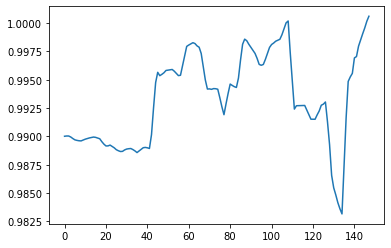

In [3]:
plt.plot(mv(gamma_buffer))

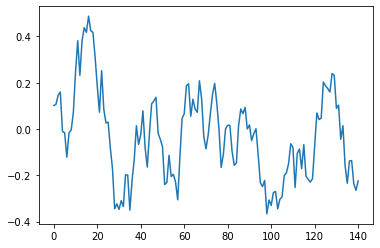

In [4]:
plt.plot(mv(angle_buffer,10))

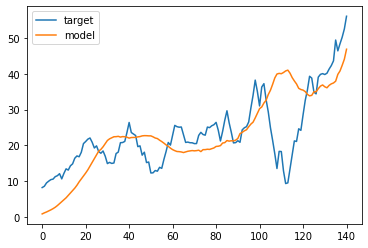

In [5]:
plt.plot(mv(target_value_buffer,10), label="target")
plt.plot(mv(estimate_value_buffer,10), label="model")
# plt.ylim([0, np.max(estimate_value_buffer)*2])
plt.legend()

In [6]:
qs

tensor([92.0339, 90.9964, 89.9593, 88.9226, 87.8864, 86.8506, 85.8152, 84.7802,
        83.7457, 82.7115, 81.6779, 80.6446, 79.6118, 78.5793, 77.5474, 76.5158,
        75.4847, 74.4540, 73.4237, 72.3938, 71.3644, 70.3354, 69.3068, 68.2786,
        67.2509, 66.2236, 65.1967, 64.1702, 63.1442, 62.1185])

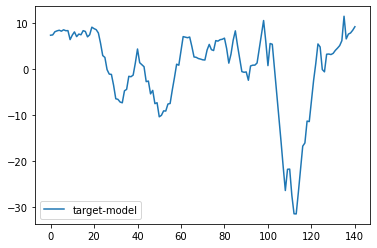

In [7]:
plt.plot(mv(target_value_buffer-estimate_value_buffer,10), label="target-model")
# plt.plot(estimate_value_buffer, label="model")
# plt.ylim([0, np.max(estimate_value_buffer)*2])
plt.legend()

In [8]:
render = True

n_episodes = 10
for i_episode in range(1, n_episodes+1):
    running_reward = 0
    state = test_task.reset()
    for test_step in range(500):
        softmax_action = torch.exp(actor_network(Variable(torch.Tensor([state]))))
        action = np.argmax(softmax_action.data.numpy()[0])
        next_state,reward,done,_ = test_task.step(action)
        result += reward
        state = next_state
        if done:
            break
        if render:
            test_task.render()
    print('Episode {}\tReward: {}'.format(i_episode, running_reward))
    test_task.reset()
    render()
    break

/home/aaron/anaconda3/envs/PT17/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 1	Reward: 0


TypeError: 'bool' object is not callable